In [38]:
import json
import re
from haralyzer import HarParser
import pandas as pd
from datetime import datetime, timezone

# Load the HAR file
with open('organic_marketing_Archive [24-10-16 20-12-10].har', 'r', encoding='utf-8') as f:
    har_parser = HarParser(json.loads(f.read()))

#Check if it has data
#data = har_parser.har_data
#print(type(data))

# Regex patterns for matching variables
patterns = {
    'username': re.compile(r'"uniqueId"\s*:\s*"([^"]+)"'),
    'nickname': re.compile(r'"nickname"\s*:\s*"([^"]+)"'),
    'bio': re.compile(r'"signature"\s*:\s*"([^"]+)"'),
    'follower_count': re.compile(r'"followerCount"\s*:\s*(\d+)'),
    #'hashtags': re.compile(r'"hashtagName"\s*:\s*"([^"]+)"'), # Only returns the first hashtag.
    'video_description': re.compile(r'"desc"\s*:\s*"([^"]+)"'),
    'upload_time': re.compile(r'"createTime"\s*:\s*(\d+)'),
    'duration': re.compile(r'"duration"\s*:\s*(\d+)'),
    'sound': re.compile(r'"title"\s*:\s*"([^"]+)"'),
    'view_count': re.compile(r'"playCount"\s*:\s*(\d+)'),
    'comment_count': re.compile(r'"commentCount"\s*:\s*(\d+)'),
    'like_count': re.compile(r'"diggCount"\s*:\s*(\d+)'),
    'save_count': re.compile(r'"collectCount"\s*:\s*(\d+)'),
    'share_count': re.compile(r'"shareCount"\s*:\s*(\d+)')
}


In [39]:
data = []

# Updated helper function to convert UNIX time to human-readable UTC format
def convert_unix_time(unix_time):
    return datetime.fromtimestamp(unix_time, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S')

# Iterate over pages and entries in the HAR file
for page in har_parser.pages:
    for entry in page.entries:
        # Ensure that the entry has a 'text' field in its response content
        response_text = entry['response']['content'].get('text', '')
        if response_text:
            # Try to load the text content as JSON (assuming it's structured that way)
            try:
                response_data = json.loads(response_text)
                
                # Extract the list of videos (inside the "data" array)
                videos = response_data.get('data', [])  # 'data' contains the list of video objects
                
                # Iterate over each video in the "data" array
                for video in videos:
                    item = video.get('item', {})  # 'item' contains the details of each video
                    
                    # Extract the data for each video (item)
                    extracted_data = {}
                    for key, pattern in patterns.items():
                        match = pattern.search(json.dumps(item))  # Search inside each item object
                        extracted_data[key] = match.group(1) if match else None

                    # Convert UNIX time for upload_date if available
                    if extracted_data.get('upload_time'):
                        extracted_data['upload_time'] = convert_unix_time(int(extracted_data['upload_time']))

                    # Add the row to the dataset if relevant data was found
                    if any(extracted_data.values()):
                        data.append(extracted_data)

            except json.JSONDecodeError:
                print("Error decoding JSON response")
                continue
# Convert to a pandas DataFrame
df = pd.DataFrame(data)

# Show the first few rows of the DataFrame to verify the extraction
print(len(df))
#print(df)


104


### Now, let's clean the data 

In [40]:
# Data from JSON file is imported as 'str' type. Convert to numeric.
# List of columns to convert to numeric
columns_to_convert = ['follower_count', 'view_count', 'comment_count', 'like_count', 'save_count', 'share_count']

# Convert all relevant columns to numeric in one step
df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce')

In [41]:
# Hashtags are at the end of the video description. Let's put those in to a new column.
def extract_hashtags(description):
    hashtags = re.findall(r'#\w+', description)

    #Remove them from description to avoid repeating data
    clean_description = re.sub(r'#\w+', '', description).strip()
    return clean_description, hashtags  

df[['video_description', 'hashtags']] = df['video_description'].apply(
    lambda desc: pd.Series(extract_hashtags(desc) if pd.notnull(desc) else ('', []))
)

#print(df)

In [42]:
# Let's convert the emoji's for the humans in the audience.
import json
# Function to decode Unicode escape sequences safely
def decode_unicode(description):
    try:
        # Add quotes around the string so json.loads correctly decodes the escape sequences
        return json.loads(f'"{description}"')
    except json.JSONDecodeError:
        return description

# List of columns to apply the decoding function
columns_to_decode = ['video_description', 'nickname', 'bio']

# Apply the decoding function in place to all specified columns
df[columns_to_decode] = df[columns_to_decode].applymap(lambda desc: decode_unicode(desc) if pd.notnull(desc) else '')

# Show the resulting DataFrame with the decoded descriptions
#print(df[['video_description']])

# Save the cleaned data to a .csv for work elsewhere
df.to_csv('cleaned_tiktok_data.csv', index=False)


C:\Users\trott\AppData\Local\Temp\ipykernel_7964\1631547309.py:15: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



### Data Aggregation

In [43]:
#Calculate the rate of engagement by looking at the ratio of interactions to views.
df['engagement_rate'] = (df['comment_count'] + df['like_count'] + df['save_count'] + df['share_count']) / df['view_count']

# Show the resulting DataFrame with the new engagement_rate column
print(df[['view_count', 'comment_count', 'like_count', 'save_count', 'share_count', 'engagement_rate']])

     view_count  comment_count  like_count  save_count  share_count  \
0        370900            319       22800       14300         1733   
1          7040              9         284          62            4   
2          4980              2         174          59            6   
3          6798              1         527         176           14   
4          3747             13         316          86           12   
..          ...            ...         ...         ...          ...   
99       164200            695        3211        1288          202   
100       34700              9        1794         369           69   
101       29800             54        1616         419           63   
102      142700            168        8313        1061         1497   
103      603200            176       27700        3759          408   

     engagement_rate  
0           0.105559  
1           0.050994  
2           0.048394  
3           0.105619  
4           0.113958  
..       

In [44]:
import plotly.express as px

## Pivot table
# Function to calculate the top hashtags by total view count, engagement rate, and other metrics
def calculate_top_hashtags(df, top_n=25):
    # Dictionary to store hashtag data
    hashtag_data = {}
    
    # Iterate through each row in the DataFrame
    for idx, row in df.iterrows():
        hashtags = row['hashtags']  # List of hashtags in the row
        view_count = row['view_count']
        comment_count = row['comment_count']
        like_count = row['like_count']
        save_count = row['save_count']
        share_count = row['share_count']
        engagement_rate = row['engagement_rate']
        
        # For each hashtag, update its total view count, engagement rate, and other metrics
        for hashtag in hashtags:
            if hashtag not in hashtag_data:
                hashtag_data[hashtag] = {
                    'total_view_count': 0,
                    'total_comment_count': 0,
                    'total_like_count': 0,
                    'total_save_count': 0,
                    'total_share_count': 0,
                    'engagement_rates': []
                }
            
            # Add view count and engagement rate to the hashtag
            hashtag_data[hashtag]['total_view_count'] += view_count
            hashtag_data[hashtag]['total_comment_count'] += comment_count
            hashtag_data[hashtag]['total_like_count'] += like_count
            hashtag_data[hashtag]['total_save_count'] += save_count
            hashtag_data[hashtag]['total_share_count'] += share_count
            hashtag_data[hashtag]['engagement_rates'].append(engagement_rate)
    
    # Create a list to store the aggregated data
    aggregated_data = []

    # Calculate the total view count, engagement rate, and other metrics for each hashtag
    for hashtag, data in hashtag_data.items():
        total_view_count = data['total_view_count']
        total_comment_count = data['total_comment_count']
        total_like_count = data['total_like_count']
        total_save_count = data['total_save_count']
        total_share_count = data['total_share_count']
        avg_engagement_rate = sum(data['engagement_rates']) / len(data['engagement_rates'])
        
        aggregated_data.append({
            'hashtag': hashtag,
            'total_view_count': total_view_count,
            'total_comment_count': total_comment_count,
            'total_like_count': total_like_count,
            'total_save_count': total_save_count,
            'total_share_count': total_share_count,
            'avg_engagement_rate': avg_engagement_rate
        })
    
    # Create a new DataFrame from the aggregated data
    hashtag_df = pd.DataFrame(aggregated_data)
    
    # Sort the DataFrame by total view count and select the top N hashtags
    top_hashtags_df = hashtag_df.sort_values(by='total_view_count', ascending=False).head(top_n)
    
    return top_hashtags_df

# Call the function and get the top 25 hashtags
top_hashtags_df = calculate_top_hashtags(df, top_n=25)

# Plot Pie Chart for Total View Count
fig_view_count = px.pie(top_hashtags_df, 
                        values='total_view_count', 
                        names='hashtag', 
                        title='Top Hashtags by Total View Count')

# Plot Pie Chart for Average Engagement Rate
fig_engagement_rate = px.pie(top_hashtags_df, 
                             values='avg_engagement_rate', 
                             names='hashtag', 
                             title='Top Hashtags by Average Engagement Rate')

# Show the two pie charts
fig_view_count.show()
fig_engagement_rate.show()

# Show the resulting DataFrame with the top 25 hashtags and their metrics
#print(top_hashtags_df.head())

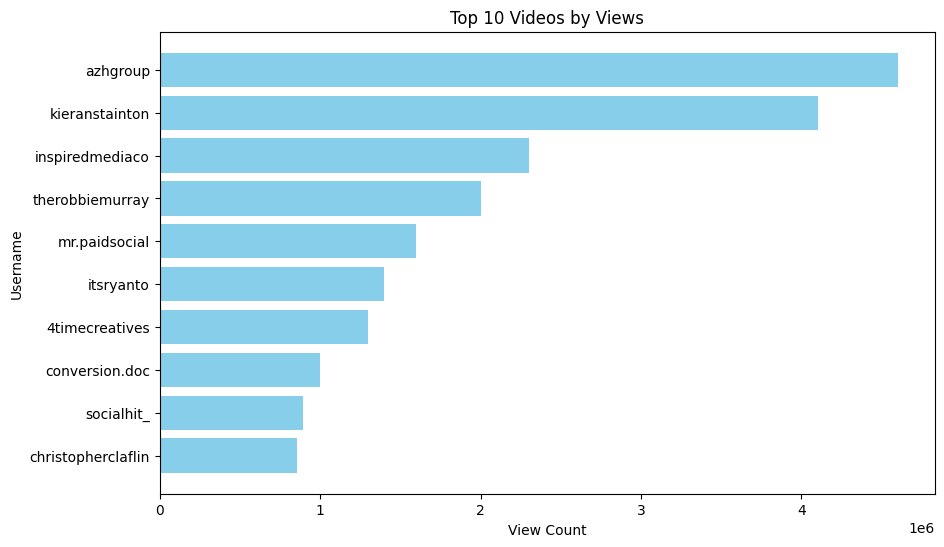

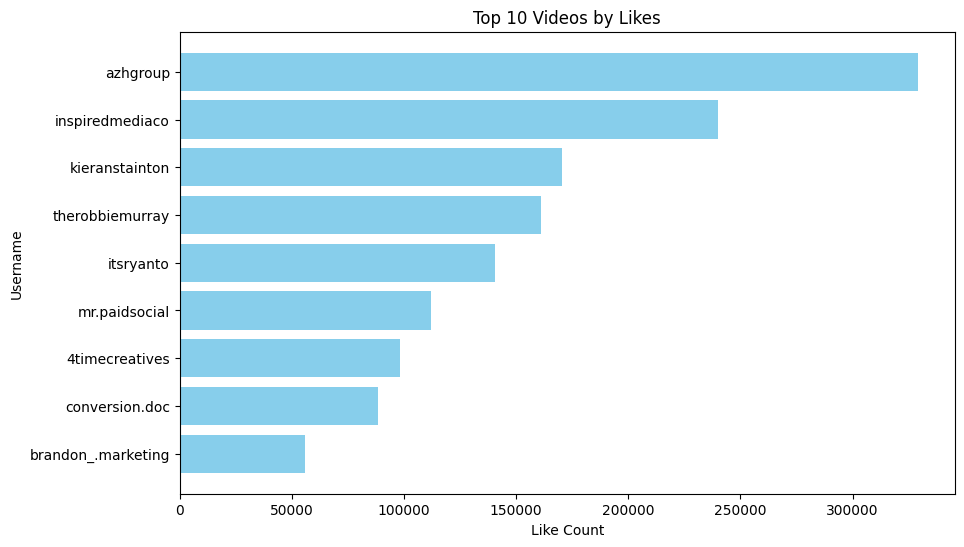

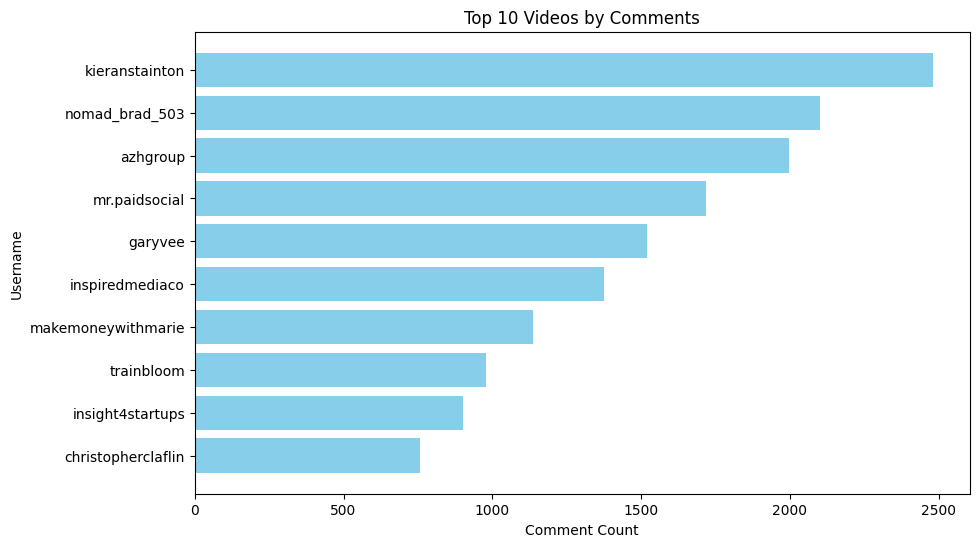

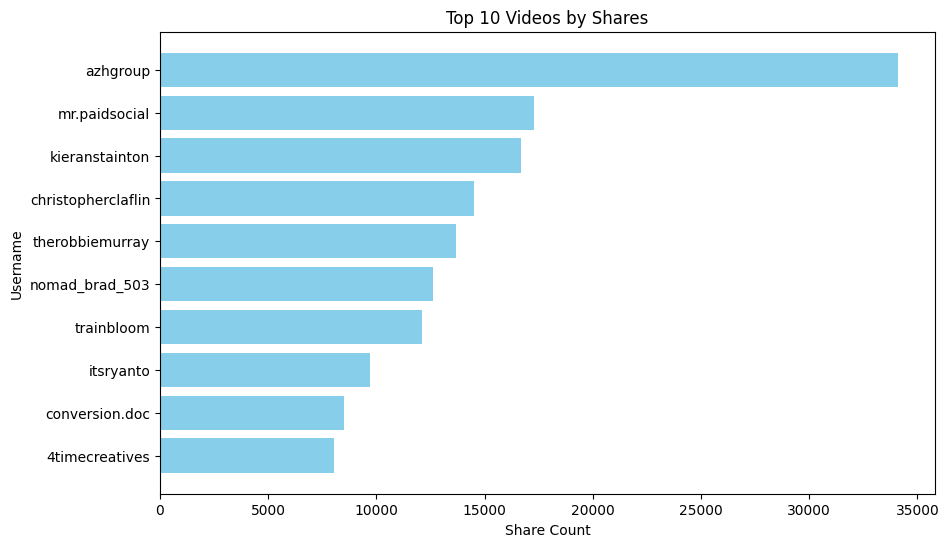

In [45]:
import matplotlib.pyplot as plt

# Function to plot the top 10 videos for a given metric
def plot_top_videos(df, metric, title, xlabel):
    # Sort the DataFrame by the selected metric and get the top 10
    top_videos = df[['username', metric]].sort_values(by=metric, ascending=False).head(10)
    
    # Plot a bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_videos['username'], top_videos[metric], color='skyblue')
    plt.title(f'Top 10 Videos by {title}')
    plt.xlabel(xlabel)
    plt.ylabel('Username')
    plt.gca().invert_yaxis()  # Invert the y-axis so the highest value is at the top
    plt.show()

# Plot the top 10 videos for views, likes, comments, and shares
plot_top_videos(df, 'view_count', 'Views', 'View Count')
plot_top_videos(df, 'like_count', 'Likes', 'Like Count')
plot_top_videos(df, 'comment_count', 'Comments', 'Comment Count')
plot_top_videos(df, 'share_count', 'Shares', 'Share Count')

In [46]:
# Convert follower_count to a numeric type if not already numeric
df['follower_count'] = pd.to_numeric(df['follower_count'], errors='coerce')

# Convert follower_count to a numeric type if not already numeric
df['follower_count'] = pd.to_numeric(df['follower_count'], errors='coerce')

# Sort the DataFrame by follower_count in ascending order
df = df.sort_values(by='follower_count', ascending=True)

# Create an interactive scatter plot with Plotly and log scale on both axes
fig = px.scatter(df, 
                 x='follower_count', 
                 y='view_count', 
                 hover_name='username',  # Display username when hovering
                 labels={'follower_count': 'Follower Count', 'view_count': 'View Count'},
                 title='View Count vs Follower Count (Log Scale)',
                 log_x=True,  # Apply logarithmic scale to x-axis
                 log_y=True)  # Apply logarithmic scale to y-axis

# Show the plot
fig.show()
